In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings 
import pickle
import pymongo
import configparser
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
df = pd.read_csv("./data/adult.csv", na_values=['nan','?'])
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
cols = {
    "education.num":"education_num",
    "marital.status":"marital_status",
    "capital.gain":"capital_gain",
    "capital.loss":"capital_loss",
    "hours.per.week":"hours_per_week",
    "native.country":"native_country"

}

df.rename(columns=cols, inplace=True)

In [4]:
print("Here is a detailed description of the dataset: \n")
df.info()
print("="*50)



Here is a detailed description of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Categorical Features
categorical_columns = [column for column in df.columns if df[column].dtype == 'O']
categorical_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'income']

In [6]:
# Quantitative Features 
numer_columns = [column for column in df.columns if column not in categorical_columns]
numer_columns

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [7]:
print("Here are Missing Data Details:\n")
print(df.isnull().sum())
print("="*50)

Here are Missing Data Details:

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64


***Features with Missing Values - workclass, occupation, native_country which are categorical features.***


In [8]:
cat_unique = {}
for col in categorical_columns:
    cat_unique[col] = df[col].nunique()

print(f"Unique Values for All Categorical Features:\n {cat_unique}") 
    

Unique Values for All Categorical Features:
 {'workclass': 8, 'education': 16, 'marital_status': 7, 'occupation': 14, 'relationship': 6, 'race': 5, 'sex': 2, 'native_country': 41, 'income': 2}


***We should use the 'education' feature only for EDA and drop it before feature engineering and model building. Since education_num is representing the education column numericallly***

In [9]:
df['occupation'].unique()

array([nan, 'Exec-managerial', 'Machine-op-inspct', 'Prof-specialty',
       'Other-service', 'Adm-clerical', 'Craft-repair',
       'Transport-moving', 'Handlers-cleaners', 'Sales',
       'Farming-fishing', 'Tech-support', 'Protective-serv',
       'Armed-Forces', 'Priv-house-serv'], dtype=object)

***Missing Values of Categorical Features are imputed with mode() function***  

In [10]:
print("""Missing Values Information """)

# features = []
for i in categorical_columns:
    if df[i].isnull().sum() != 0:
        # features.append(i)
        print(f"{i} Missing Data (in %): {round(((df[i].isnull().sum()/len(df))*100),2)}%\n")
        
        df[i] = df[i].fillna(df[i].mode()[0])

        

Missing Values Information 
workclass Missing Data (in %): 5.64%

occupation Missing Data (in %): 5.66%

native_country Missing Data (in %): 1.79%



In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education_num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital_gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital_loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours_per_week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


***After Analyzing the "fnlwgt" column it is clear that this feature is very discrete and the range is too big for it to be uniform or informative. Therefore, Drop this column as it does not add to the model accuracy***

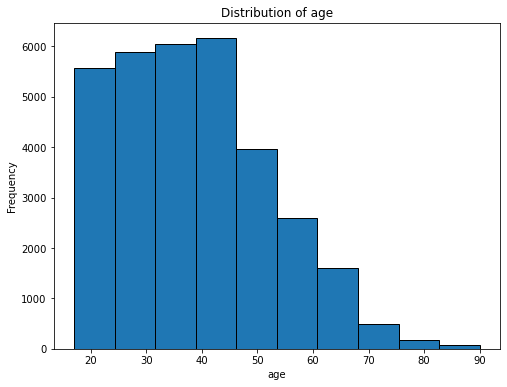

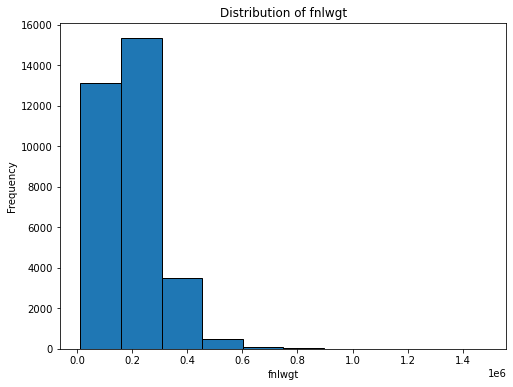

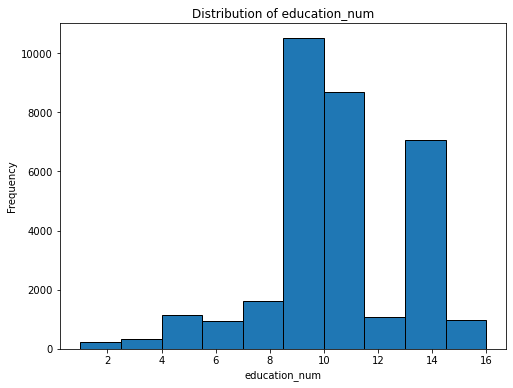

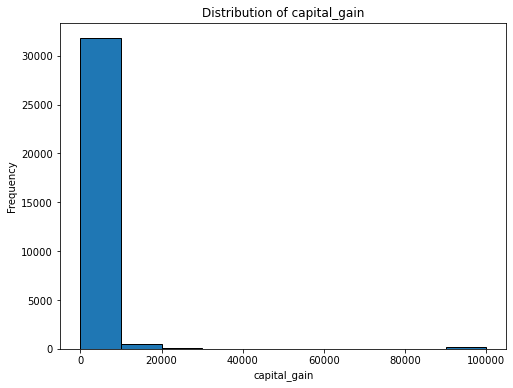

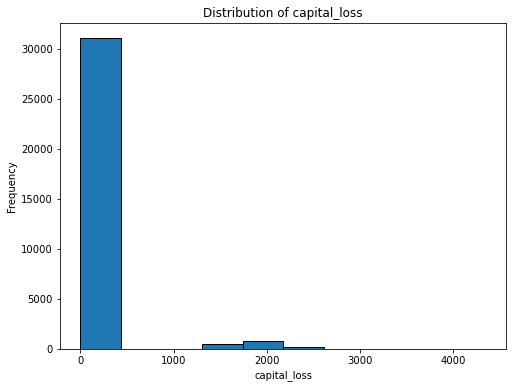

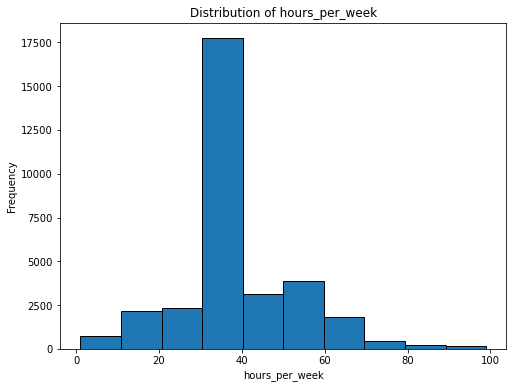

In [12]:
# Numerical Feature Analysis
# Histogram for all the numerical features
for feature in numer_columns:
    plt.figure(figsize=(8,6))
    plt.hist(df[feature], bins=10, edgecolor='k')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

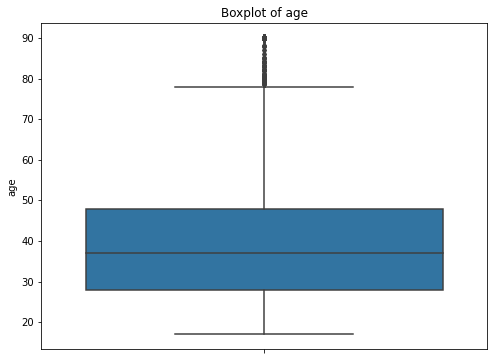

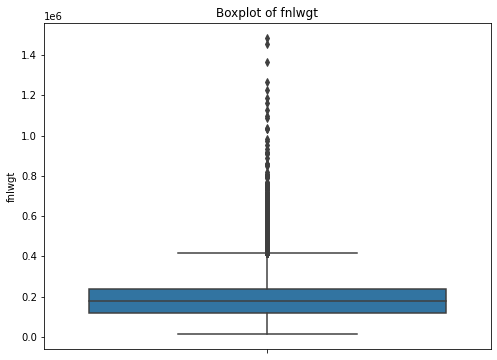

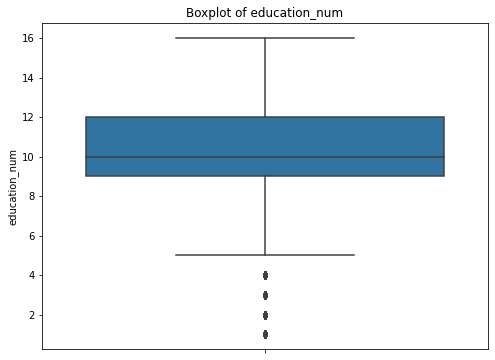

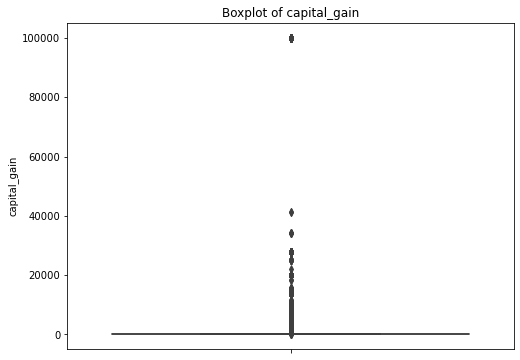

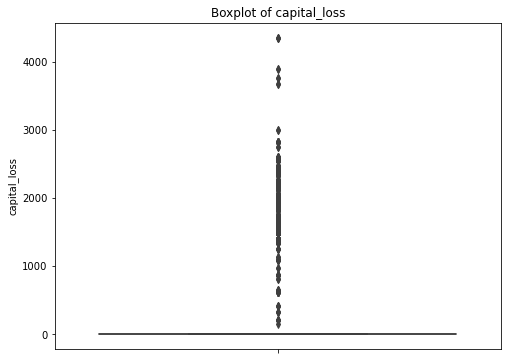

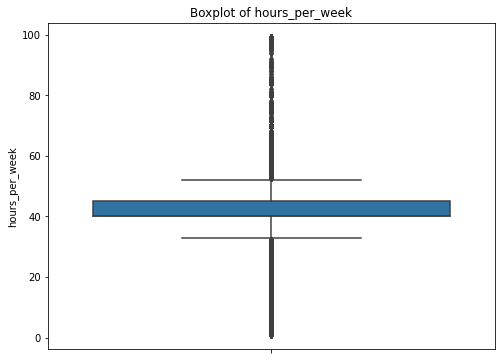

In [13]:
# Boxplot 
for feature in numer_columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, y=feature)
    plt.title(f"Boxplot of {feature}")
    plt.ylabel(feature)
    
    plt.show()

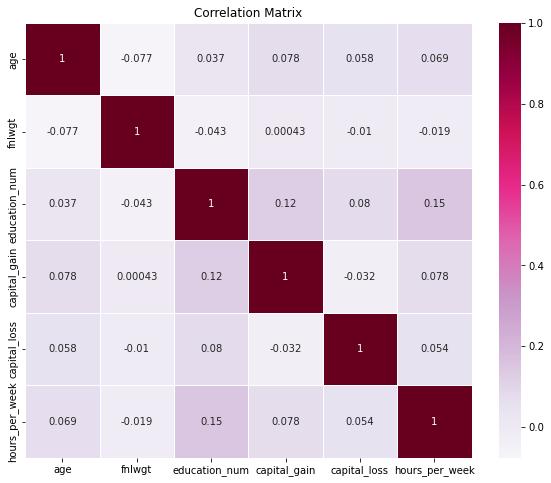

In [14]:
# Correlation Matrix
correlation_matrix = df[numer_columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='PuRd', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [15]:
# Categorical Feature Analysis 
cat_unique

{'workclass': 8,
 'education': 16,
 'marital_status': 7,
 'occupation': 14,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native_country': 41,
 'income': 2}

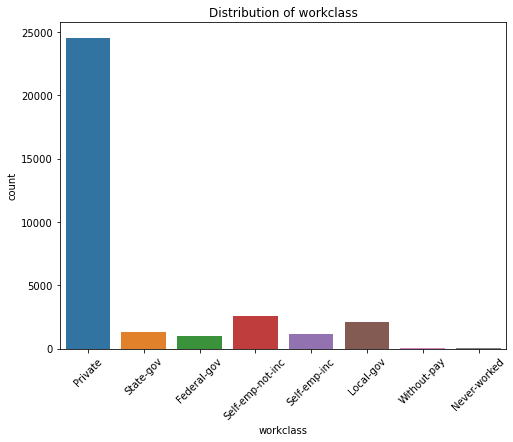

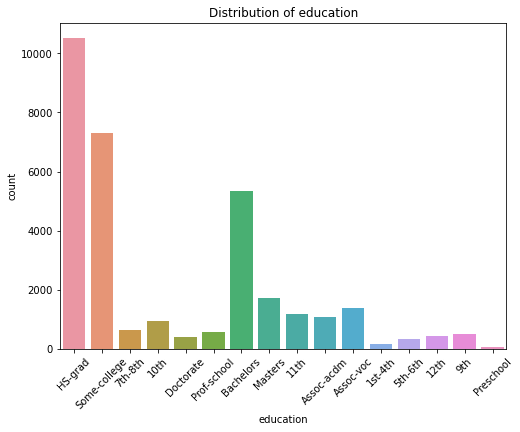

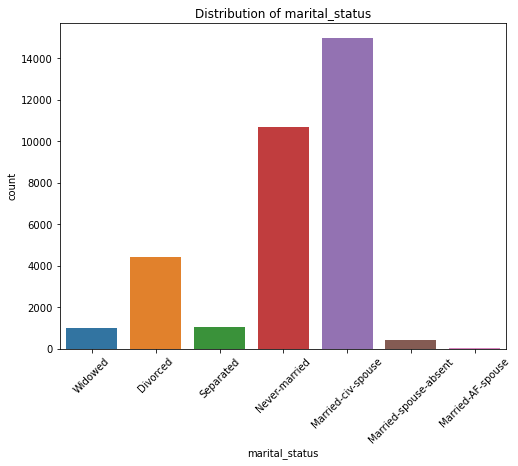

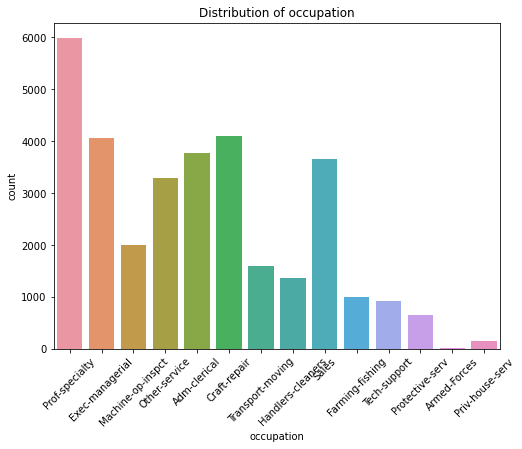

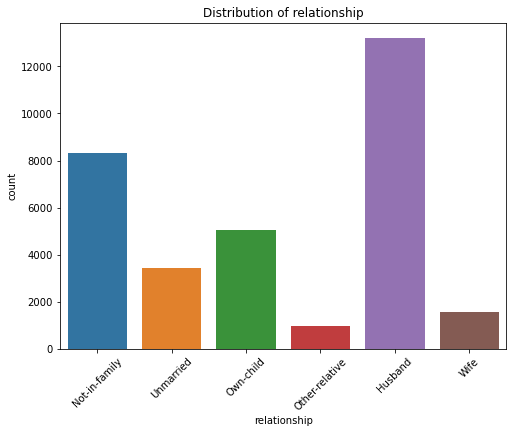

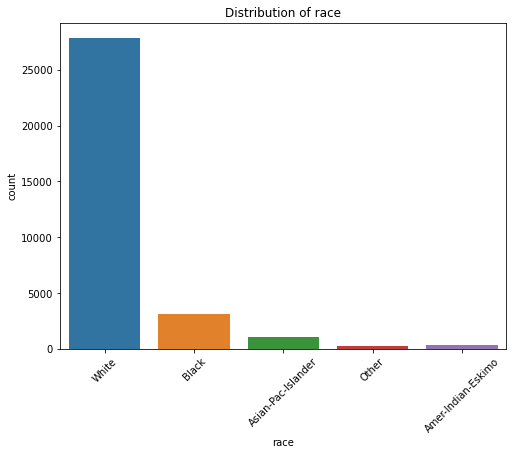

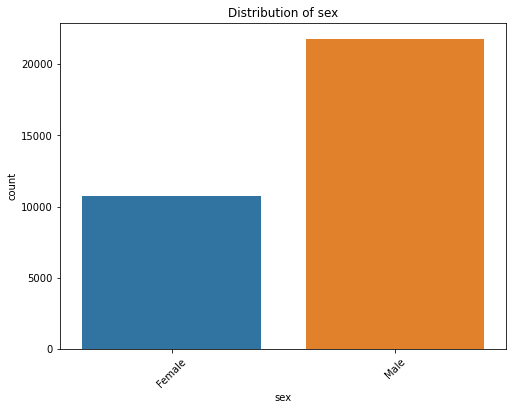

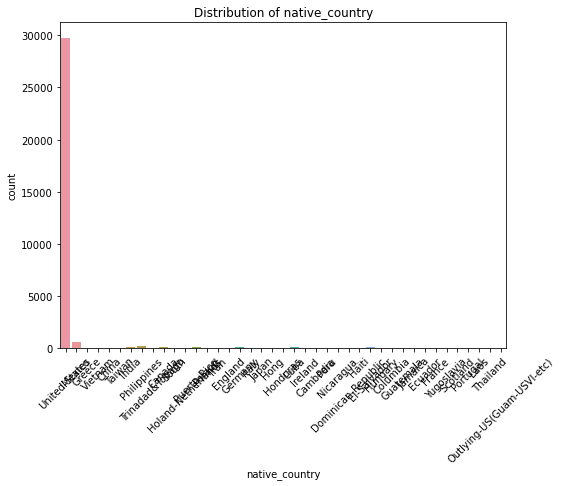

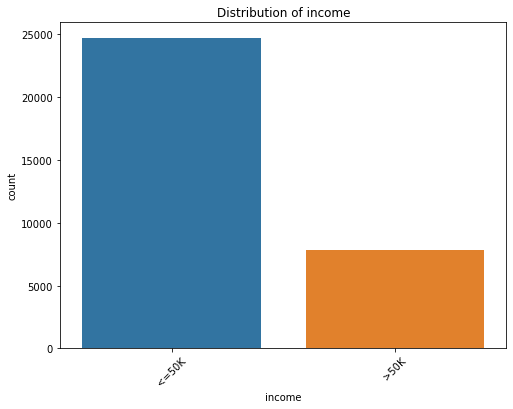

In [16]:
for feature in cat_unique.keys():
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

<AxesSubplot:xlabel='income', ylabel='count'>

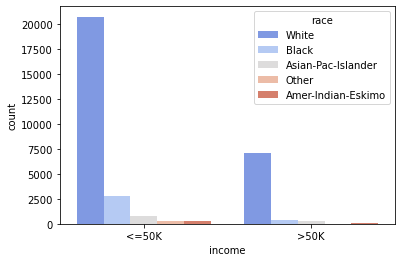

In [17]:
sns.countplot(df['income'], palette='coolwarm', hue='race', data=df)

<AxesSubplot:xlabel='income', ylabel='count'>

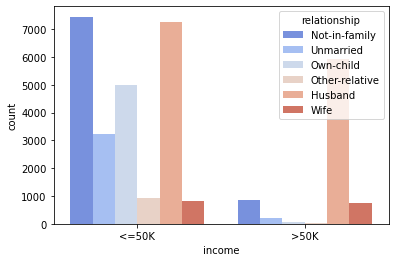

In [18]:
sns.countplot(df['income'], palette='coolwarm', hue='relationship', data=df)

<AxesSubplot:xlabel='income', ylabel='count'>

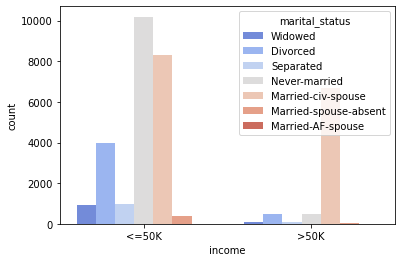

In [19]:
sns.countplot(df['income'], palette='coolwarm', hue='marital_status', data=df)

<AxesSubplot:xlabel='income', ylabel='count'>

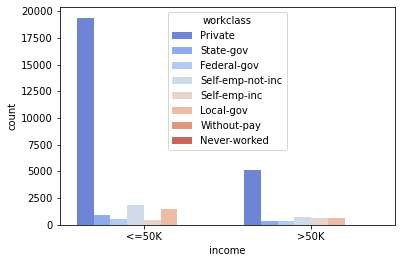

In [20]:
sns.countplot(df['income'], palette='coolwarm', hue='workclass', data=df)

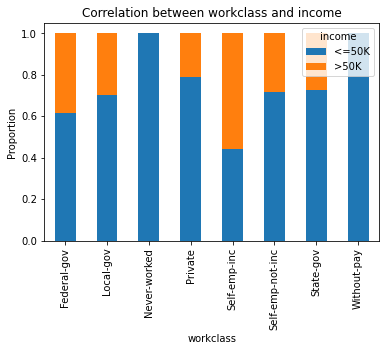

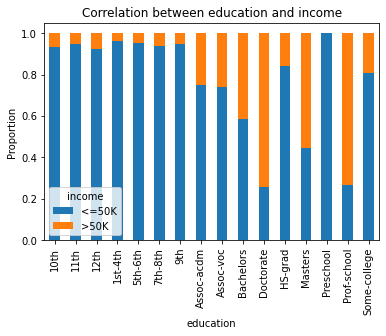

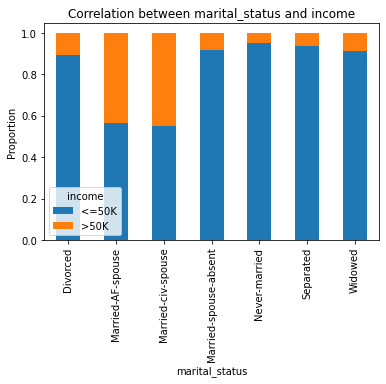

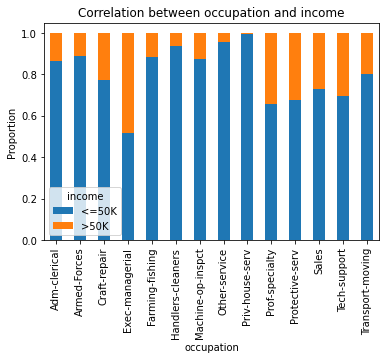

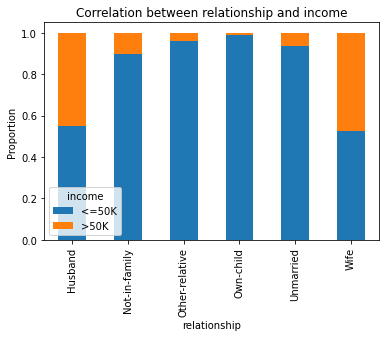

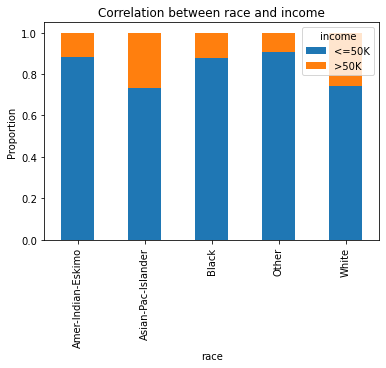

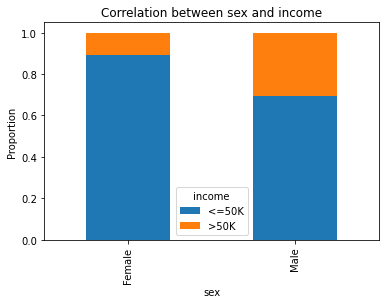

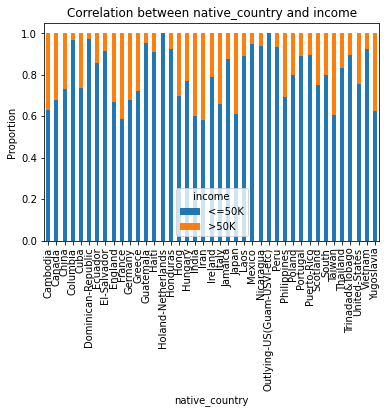

In [21]:
for feature in categorical_columns:
    if feature != 'income':
        cross_table = pd.crosstab(df[feature], df['income'])
        cross_table.div(cross_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
        plt.title(f'Correlation between {feature} and income')
        plt.xlabel(feature)
        plt.ylabel('Proportion')
        plt.show()

## Feature Engineering and Transformation 

In [22]:
# Dropping Features
df.drop(['fnlwgt','education'], axis=1 , inplace=True)
df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [23]:
cat_unique

{'workclass': 8,
 'education': 16,
 'marital_status': 7,
 'occupation': 14,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native_country': 41,
 'income': 2}

***Here we can see that only the 'sex' is binary feature while the rest are nominal feature***

In [24]:
df['sex'] = np.where(df['sex']=='male', 1,0)
df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,0,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,<=50K
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,0,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States,<=50K


In [25]:
X = df.drop('income', axis=1)
y = df['income']


In [26]:
X.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,0,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,0,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States


In [27]:
def cat_encoder(df, columns):
    label_encoder = LabelEncoder()
    for feature in columns:
        if feature != 'income' and feature != 'education':
            df[feature] = label_encoder.fit_transform(df[feature])
    
    return df


In [28]:
X = cat_encoder(X, categorical_columns)
X.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,90,3,9,6,9,1,4,0,0,4356,40,38
1,82,3,9,6,3,1,4,0,0,4356,18,38
2,66,3,10,6,9,4,2,0,0,4356,40,38
3,54,3,4,0,6,4,4,0,0,3900,40,38
4,41,3,10,5,9,3,4,0,0,3900,40,38


In [29]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_mappings = {index:label for index, label in enumerate(encoder.classes_)}
y_mappings

{0: '<=50K', 1: '>50K'}

In [30]:
y 

array([0, 0, 0, ..., 1, 0, 0])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=10)


In [32]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training Model 

In [33]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

LogisticRegression()

In [34]:
y_pred = model_log.predict(X_test)
accuracy_scr = accuracy_score(y_test, y_pred)
print(accuracy_scr)

0.8208635771449841


In [35]:
mat = confusion_matrix(y_test, y_pred)
print(mat)

[[7717  428]
 [1497 1104]]


In [36]:
tp = mat[0][0]
fp = mat[0][1]
fn = mat[1][0]
tn = mat[1][1]

In [37]:
acc = (tp+tn)/(tp+fp+fn+tn)
print(acc)

0.8208635771449841


In [38]:
precision = tp/(tp+fp)

In [39]:
recall = tp/(tp+fn)

In [40]:
f1_score = 2*(recall*precision)/(recall+precision)
f1_score

0.8891065153522668

### Hyperparameter Tuning 

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [42]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [ 'l2']
}

In [43]:
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs', penalty='l2'), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']})

In [44]:
random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, n_iter=5, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l2']})

In [45]:
best_model = grid_search.best_estimator_  # or random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Model Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Best Model Accuracy: 0.8224455611390284
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      8145
           1       0.72      0.43      0.54      2601

    accuracy                           0.82     10746
   macro avg       0.78      0.69      0.72     10746
weighted avg       0.81      0.82      0.81     10746



### SVM

In [46]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [47]:
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.846175321049693


In [48]:
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      8145
           1       0.77      0.52      0.62      2601

    accuracy                           0.85     10746
   macro avg       0.81      0.74      0.76     10746
weighted avg       0.84      0.85      0.84     10746



In [52]:
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.01, 0.1],
}


In [53]:
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'degree': [2, 3, 4], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=2)

In [54]:
best_model = grid_search.best_estimator_
best_model

SVC(degree=2, gamma=0.1)

In [55]:
best_params = grid_search.best_params_
print(best_params)

{'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [56]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [57]:
print(accuracy)

0.8254234133631119
